In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / 'label_anything'))
sys.path.append(str(Path.cwd().parent / 'label_anything' / 'data'))

In [2]:
from data.dataset import LabelAnythingDataset, VariableBatchSampler
from transforms import CustomResize, CustomNormalize

from label_anything import LabelAnything
from label_anything.data import get_preprocessing
from label_anything.experiment.substitution import Substitutor
from label_anything.models import model_registry
from label_anything.utils.utils import ResultDict
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
from torchvision.transforms import Compose, ToTensor, Resize, PILToTensor
from torchvision.transforms.functional import resize
from torch.utils.data import DataLoader
import timeit
from PIL import Image
import numpy as np
import cv2
import lovely_tensors as lt
from einops import rearrange
from sklearn.decomposition import PCA
import torch.nn as nn
lt.monkey_patch()

/home/pasquale/miniconda3/envs/label-anything/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%matplotlib inline

In [4]:
# Functions for visualization

def get_image(image_tensor):
    MEAN = np.array([123.675, 116.280, 103.530]) / 255
    STD = np.array([58.395, 57.120, 57.375]) / 255
    unnormalized_image = (image_tensor.numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return Image.fromarray(unnormalized_image)

def draw_masks(img: Image, masks: torch.Tensor, colors):
    # here masks is a dict having category names as keys
    # associated to a list of binary masks
    masked_image = resize(img.copy(), 256)
    
    for i, mask in enumerate(masks):
        mask = mask.numpy()
        masked_image = np.where(np.repeat(mask[:, :, np.newaxis], 3, axis=2),
                                np.asarray(colors[i], dtype="uint8"),
                                masked_image)
    
    masked_image = masked_image.astype(np.uint8)
    return cv2.addWeighted(np.array(resize(img, 256)), 0.3, masked_image, 0.7, 0)

def draw_boxes(img: Image, boxes: torch.Tensor, colors):
    img = np.array(img)
    
    for i, cat in enumerate(boxes):
        for box in cat:
            x1, y1, x2, y2 = box
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[i], 2)
    return img

def draw_points(img: Image, points: torch.Tensor, colors):
    img = np.array(img)
    
    for i, cat in enumerate(points):
        for point in cat:
            x, y = point
            x, y = int(x), int(y)
            img = cv2.circle(img, (x, y), 5, colors[i], -1)
    return img

def draw_all(img: Image, masks, boxes, points, colors):
    segmented_image = draw_masks(img, masks, colors)
    img = Image.fromarray(segmented_image)
    img = resize(img, 480)
    img = draw_boxes(img, boxes, colors)
    img = Image.fromarray(img)
    img = draw_points(img, points, colors)
    img = Image.fromarray(img)
    return img

def resize_ground_truth(ground_truth, dims):
    return ground_truth[:dims[0], :dims[1]]


colors = [
    # yellow
    (255, 255, 0),
    # red
    (255, 0, 0),
    # green
    (0, 255, 0),
    # blue
    (0, 0, 255),
    # purple
    (255, 0, 255),
    # cyan
    (0, 255, 255),
    # orange
    (255, 165, 0),
    # pink
    (255, 192, 203),
    # brown
    (139, 69, 19),
    # grey
    (128, 128, 128),
    # black
    (0, 0, 0)
]*3

In [5]:
RAW_DATA_DIR = Path.cwd().parent / "data"

In [6]:
dataset_params = {
    "datasets": {
        "val_pascal5i_N1K1": {
            "name": "pascal",
            "data_dir": RAW_DATA_DIR / "pascal",
            "split": "val",
            "val_fold_idx": 1,
            "n_folds": 4,
            "n_shots": 1,
            "n_ways": 1,
            "do_subsample": False
        }
    },
    "common": {
        "remove_small_annotations": True,
        "image_size": 384,
        "custom_preprocess": False
    }
}

In [7]:
preprocess = get_preprocessing(dataset_params)

In [8]:
val_datsets = {}
common_params = dataset_params["common"]
for name, single_dataset_params in dataset_params["datasets"].items():
    splits = name.split("_")
    if len(splits) > 2:
        dataset_name = "_".join(splits[:2])
    dataset = LabelAnythingDataset(
        datasets_params={dataset_name: single_dataset_params},
        common_params={**common_params, "preprocess": preprocess},
    )
    val_datsets[name] = dataset

Loading image filenames from val...
[2024-11-21 11:22:59] WARNING - pascal.py - load_embeddings is not specified. Assuming load_embeddings=False.


Loading annotations...: 100%|██████████| 1449/1449 [00:02<00:00, 681.92it/s]


In [9]:
sampler = VariableBatchSampler(
        dataset,
        possible_batch_example_nums=[[1, 2, 1]],
        num_processes=1,
        shuffle=False,
)

In [10]:
val_datsets.keys()

dict_keys(['val_pascal5i_N1K1'])

In [11]:
chosen_dataset = "val_pascal5i_N1K1"

dataset = val_datsets["val_pascal5i_N1K1"]

In [12]:
dataloader = DataLoader(
        dataset=dataset, batch_sampler=sampler, collate_fn=dataset.collate_fn
)

In [13]:
model = model_registry['dcama'](
    backbone_checkpoint="../checkpoints/swin_base_patch4_window12_384.pth",
    model_checkpoint="../checkpoints/swin_fold3.pt"
)

In [35]:
idx = 0
for batch_idx, ((batch, gt), _) in enumerate(dataloader):
    print(batch_idx)
    if batch_idx == idx:
        break 

0


In [36]:
sample = {
    k: v[0] for k, v in batch.items()
}

In [37]:
images = [
    draw_all(
        get_image(sample["images"][i]),
        sample["prompt_masks"][i],
        sample["prompt_bboxes"][i],
        sample["prompt_points"][i],
        colors
    )
    for i in range(sample["images"].shape[0])
]

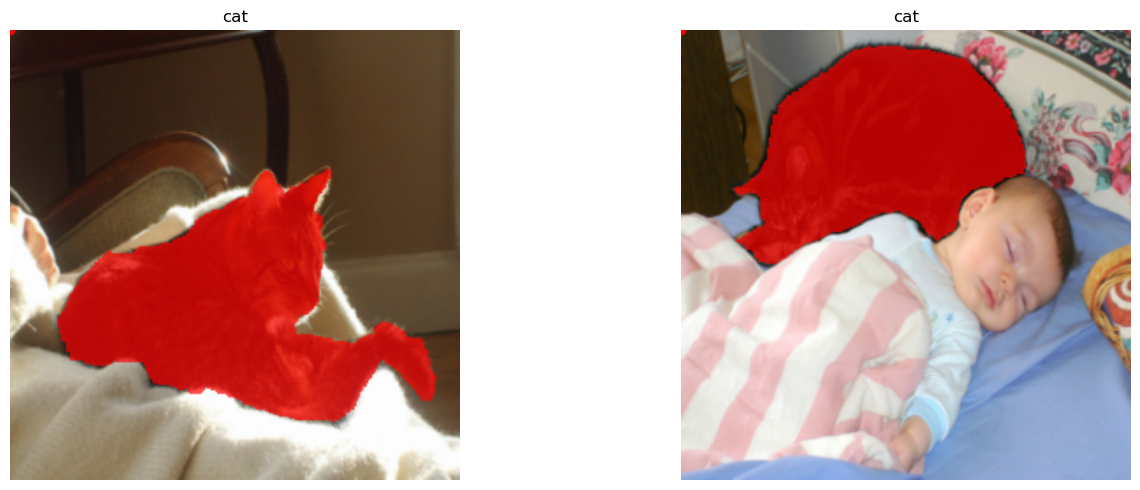

In [38]:
# show examples in a single figure
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
for i, (example, ax) in enumerate(zip(images, axes)):
    cats = [dataset.categories["val_pascal5i"][cat]["name"] for cat in sample["classes"][i]]
    ax.set_title(", ".join(cats))
    ax.imshow(example)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [39]:
sub = Substitutor(substitute=False)
sub.reset((batch, gt))
batch_dict, gt = next(sub)

In [41]:
batch_dict['prompt_masks']

tensor[1, 1, 2, 256, 256] n=131072 (0.5Mb) x∈[0., 1.000] μ=0.098 σ=0.298

In [34]:
with torch.no_grad():
    result = model(batch_dict)

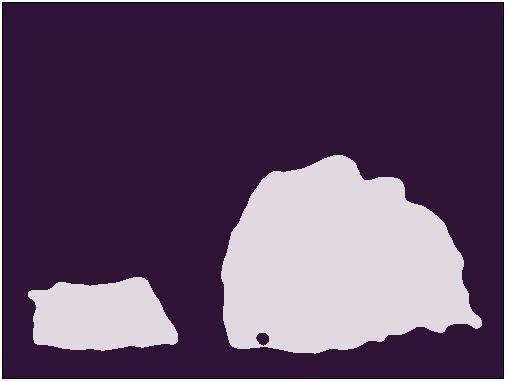

In [20]:
seg = result['logits'].argmax(1)
seg = seg / seg.max()
seg.chans